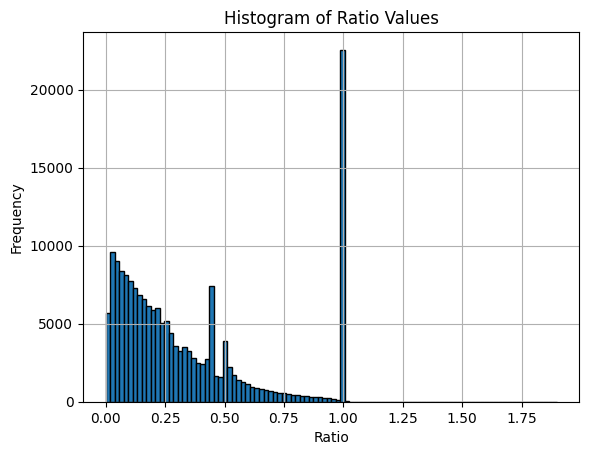

In [1]:
import re
import matplotlib.pyplot as plt

# Read the file
with open("parse.out", "r") as file:
    content = file.read()

# Extract all ratio values using regex
ratios = [float(match) for match in re.findall(r"ratio:\s*([\d.]+)", content)]

# Plot the histogram
plt.hist(ratios, bins=100, edgecolor='black')
plt.title("Histogram of Ratio Values")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [3]:
import json
from itertools import combinations

# ---- Utility Functions ----

import math

def area(rect):
    # Constants
    R_EARTH = 6371000  # radius in meters
    DEG_TO_RAD = math.pi / 180.0

    lat1, lat2 = rect['low'][1], rect['high'][1]
    lon1, lon2 = rect['low'][0], rect['high'][0]

    # Calculate lat/lon difference in radians
    dlat = abs(lat2 - lat1) * DEG_TO_RAD
    dlon = abs(lon2 - lon1) * DEG_TO_RAD

    # Use average latitude for longitude distance scaling
    avg_lat = (lat1 + lat2) / 2.0 * DEG_TO_RAD
    width_m = R_EARTH * dlon * math.cos(avg_lat)
    height_m = R_EARTH * dlat

    return abs(width_m * height_m)


def intersect(rect1, rect2):
    low_x = max(rect1['low'][0], rect2['low'][0])
    low_y = max(rect1['low'][1], rect2['low'][1])
    high_x = min(rect1['high'][0], rect2['high'][0])
    high_y = min(rect1['high'][1], rect2['high'][1])
    
    if high_x > low_x and high_y > low_y:
        return {'low': [low_x, low_y], 'high': [high_x, high_y]}
    return None

# ---- Load Data from File ----
with open('a.json', 'r') as f:
    data = json.load(f)

# ---- Build ID Map ----
id_map = {item['id']: item for item in data}

# ---- Calculate Overlap and Dead Space ----
results = {}

for item in data:
    if 'children' in item:
        children = item['children']
        child_rects = [id_map[child_id]['rectangle'] for child_id in children]

        # Total Overlap Area
        overlap_area = 0.0
        for r1, r2 in combinations(child_rects, 2):
            inter = intersect(r1, r2)
            if inter:
                overlap_area += area(inter)

        # Total area of all child rectangles
        total_child_area = sum(area(r) for r in child_rects)
        node_area = area(item['rectangle'])

        dead_space = node_area - total_child_area + overlap_area

        results[item['id']] = {
            'overlap_area': overlap_area,
            'dead_space': dead_space,
            'node_area': node_area,
            'child_area_sum': total_child_area
        }

# ---- Output Results ----
import pprint
pprint.pprint(results)


{0: {'child_area_sum': 124099410.10733812,
     'dead_space': 1405712170879.0293,
     'node_area': 1405836270289.1367,
     'overlap_area': 0.0},
 2: {'child_area_sum': 328774591.8254856,
     'dead_space': 375935570.521206,
     'node_area': 669637773.7938765,
     'overlap_area': 35072388.55281506},
 3: {'child_area_sum': 1725311946.6345985,
     'dead_space': 3756995711.5166736,
     'node_area': 5387429813.8196535,
     'overlap_area': 94877844.3316187},
 4: {'child_area_sum': 1018880207.0917982,
     'dead_space': 1155082005378.535,
     'node_area': 1156020427499.0688,
     'overlap_area': 80458086.5578694}}


In [ ]:
!pip install folium
import folium
import json

# Load data from JSON file
with open('a.json', 'r') as f:
    data = json.load(f)

# Create a base map centered on a central latitude/longitude point
# You can choose a different starting point based on your data's coordinates
center_lat = 35.0
center_lon = -78.0
map_obj = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Loop through each rectangle and draw on the map
for item in data:
    if 'rectangle' in item:
        rect = item['rectangle']
        low_lat, low_lon = rect['low'][1], rect['low'][0]
        high_lat, high_lon = rect['high'][1], rect['high'][0]
        
        # Draw the rectangle on the map
        folium.Rectangle(
            bounds=[[low_lat, low_lon], [high_lat, high_lon]],
            color="blue",  # You can change the color
            weight=2,
            fill=True,
            fill_color="blue",  # Rectangle fill color
            fill_opacity=0.2
        ).add_to(map_obj)

# Save the map as an HTML file
map_obj.save('rectangles_map.html')

# Optionally, open the map in the default web browser
import webbrowser
webbrowser.open('rectangles_map.html')



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
